In [1]:
# Wavefunction generation
from pyscf import mcscf, fci, lib 
from pyscf import gto, scf, tools, dft
import api as pyq 
import importlib
import os
import h5py
import pandas as pd
import pdb
import pyscf
import numpy as np
import pyqmc
import scipy
import matplotlib.pyplot as plt
from pyscf.scf.hf import dump_scf_summary
from concurrent.futures import ProcessPoolExecutor
from pyscf.scf.chkfile import dump_scf
print(pyq.__file__)
print(pyscf.__file__)

/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


/Users/ksu/Documents/GitHub/pyqmc/pyqmc/api.py
/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/__init__.py


In [2]:
# H2 molecule
def run_scf(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.;H 0. 0. 1.;", basis=f'ccecpccpvdz', unit='bohr')
    mf = scf.UHF(mol)
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm)
    dump_scf(mf.mol, 'scf.hdf5', mf.energy_tot(), mf.mo_energy, mf.mo_coeff, mf.mo_occ)
    return mf

def run_lda_be(scf_checkfile):
    print("Be atom neutral LDA spin=2")
    mol = gto.M(atom="Be 0. 0. 0.", spin=2,basis=f'ccpvdz', unit='bohr')
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")        
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_li(scf_checkfile):
    print("Li atom neutral LDA spin=1")
    mol = gto.M(atom="Li 0. 0. 0.",basis=f'ccpvtz', spin=1, unit='bohr')
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")    
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_he(scf_checkfile):
    print("He atom neutral LDA spin=0")
    # mol = gto.M(atom="He 0. 0. 0.", basis="ccECP_cc-pVDZ", ecp="ccecp", unit='bohr')
    mol = gto.M(atom="He 0. 0. 0.", basis="ccpvdz", unit='bohr')    
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")    
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_h2(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.; H 0. 0. 2", spin = 2, basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.xc='LDA, VWN'
    mf.kernel()    
    # mf.kernel(dm, xc='LDA,VWN')
    return mf

def run_lda(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.", spin=1,basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf
    
def run_casscf(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    mc = mcscf.CASSCF(mf,2,2)
    mc.chkfile = ci_checkfile
    mc.kernel()
    with h5py.File(mc.chkfile, "a") as f:
        print("Available output from CASSCF:", f["mcscf"].keys())
        f["mcscf/nelecas"] = list(mc.nelecas)
        f["mcscf/ci"] = mc.ci
    return mc

def run_casci(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    # ncas: orbitals
    # nelecas: electrons
    ncas = 4
    nelecas = 2
    mc = mcscf.CASCI(mf, ncas, nelecas)
    mc.kernel()
    print(mc.__dict__.keys())
    with h5py.File(ci_checkfile, "a") as f:
        f.create_group("ci")
        f["ci/ncas"] = mc.ncas
        f["ci/nelecas"] = list(mc.nelecas)
        f["ci/ci"] = mc.ci
        f["ci/mo_coeff"] = mc.mo_coeff
        print("Available output from CASCI:", f["ci"].keys())
    return mc

def make_wf_object(scf_checkfile, ci_checkfile):
    mol, mf, mc = pyq.recover_pyscf(scf_checkfile, ci_checkfile=ci_checkfile)
    wf, _ = pyq.generate_wf(mol, mf, mc=mc)
    return wf

def stat_qmc(etot, filename):
    block_sizes = np.linspace(2,len(etot[discard:])//16, 10, dtype=int)
    reblocks = [len(etot)//s for s in block_sizes]

    plt.figure()
    df = pd.DataFrame([pyq.read_mc_output(filename, warmup=discard, reblock=reblock) for reblock in reblocks])
    df['block_size'] = block_sizes
    plt.plot("block_size",'energytotal_err',data=df, marker='o')
    plt.xlabel("Block size")
    plt.ylabel("Estimated uncertainty (Ha)")

def reblock(e, discard, reblock_size):
    e = e[discard:]
    vals = pyqmc.reblock.reblock(e,int(len(e)/reblock_size))
    # import pdb
    # pdb.set_trace()
    
    e_m  = np.mean(vals, axis=0)
    e_d  = scipy.stats.sem(vals, axis=0)    
    return e, e_m, e_d

scf_checkfile = "scf.hdf5"
ci_checkfile = "ci.hdf5"
# mf = run_scf(scf_checkfile)
mf_lda = run_lda_he(scf_checkfile)

# mc = run_casci(scf_checkfile, ci_checkfile)

He atom neutral LDA spin=0
HF
converged SCF energy = -2.85516047724274  <S^2> = 0  2S+1 = 1
LDA
converged SCF energy = -2.82670655418611  <S^2> = 4.4408921e-16  2S+1 = 1


In [3]:
tstep = 0.001
nconfig = 2000
nsteps = 1000
discard = 100
reblock_size = 50

In [6]:
# #PYQMC VMC 
# #
# #
# import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
# modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
# for m in modules:
#     importlib.reload(m)
# # Jastrow optimization
# for fname in ['vmc_001.hdf5']:
#     if os.path.isfile(fname):
#         os.remove(fname)
# from recipes import ABDMC, DMC, ABVMC, VMC
# npartitions = 16
# # with ProcessPoolExecutor(max_workers=npartitions) as client:
# #     pyqmc.recipes.VMC("scf.hdf5", "vmc_001.hdf5",  verbose=False, nsteps =nsteps, tstep= tstep, nconfig=nconfig, client=client, npartitions=npartitions)

# VMC("scf.hdf5", "vmc_001.hdf5",  verbose=True, nsteps =nsteps, tstep= tstep, nconfig=nconfig)    

In [7]:
# #ABVMC 
# #
# #
# import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
# modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
# for m in modules:
#     importlib.reload(m)
# # Jastrow optimization
# for fname in ['abvmc-j-001.hdf5']:
#     if os.path.isfile(fname):
#         os.remove(fname)
# from recipes import ABDMC, DMC, ABVMC, VMC

# ABVMC("scf.hdf5", "abvmc-j-001.hdf5", verbose=True,  nsteps =nsteps, tstep= tstep, nconfig=nconfig)

In [17]:
import importlib, recipes, jastrowspin, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, jastrowspin, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)

    # Jastrow optimizationn
    
for fname in ['sj.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)

# pyq.OPTIMIZE(scf_checkfile, "sj.hdf5", ci_checkfile=ci_checkfile, max_iterations=2, verbose=False)
recipes.ABOPTIMIZE(scf_checkfile, "sj.hdf5", max_iterations=2, nconfig=100, verbose=False)

# Jastrow optimization results
df = pyq.read_opt("sj.hdf5")
df

Number of determinants in the bosonic wavefunction= 1
Using spherical guess
it 0 ====================
x0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
en -2.6847488243519018 en_err 0.09204639449242155
pgrad [0.00219997 0.07499197 0.04190962 0.23557581 0.11893173 0.48961249
 0.14544854 0.67026689 0.         0.11686526 0.         0.
 0.26171633 0.         0.         0.28753476 0.        ]
params [array([-0.01422343, -0.01756899, -0.0114662 , -0.00430918,  0.02535221,
        0.11697056,  0.05936165,  0.29049515,  0.        , -0.01026553,
        0.        ,  0.        ,  0.03852086,  0.        ,  0.        ,
        0.08457917,  0.        ]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([ 0.01422343,  0.01756899,  0.0114662 ,  0.00430918, -0.02535221,
       -0.11697056, -0.05936165, -0.29049515,  0.        ,  0.01026553,
        0.        ,  0.        , -0.03852086,  0.        ,  0.        ,
       -0.08457917,  0.        ]), array([ 0.028446

,energy,iteration,error,fname
0,-2.684749,0,0.092046,sj.hdf5
1,-2.985179,1,0.016354,sj.hdf5


In [18]:
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
import pyqmc.pyscftools as pyscftools
from accumulators import ABQMCEnergyAccumulator

def initialize_boson_qmc_objects(
    dft_checkfile,
):  
    mol, mf = pyscftools.recover_pyscf(scf_checkfile)
    wf, to_opt = wftools.generate_boson_wf(
        mol, mf, jastrow = None
    )
    return wf

def initialize_qmc_objects(
    dft_checkfile: str,
):
    mol, mf = pyscftools.recover_pyscf(dft_checkfile)
    wf, to_opt = wftools.generate_wf(
        mol, mf, jastrow=None
    )
    return wf

In [9]:
# aa=wfb.gradient_value(e, configs.electron(e))
# aa[1]['psi']

Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in th

Text(0.5, 1.0, '100 trials')

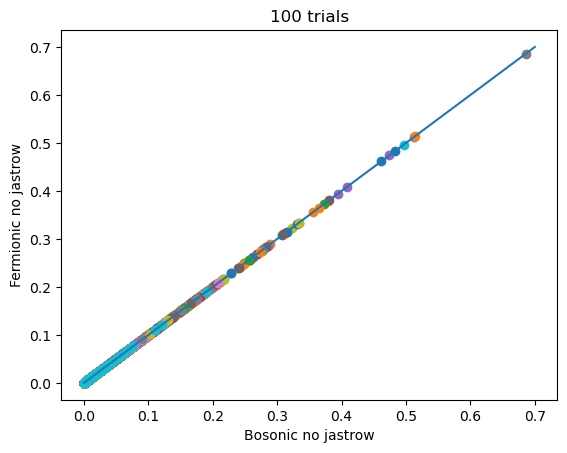

In [14]:
trials = 100
for i in range(trials):
    nconfig = 100
    mol, mf = pyscftools.recover_pyscf(scf_checkfile)
    configs = mc.initial_guess(mol, nconfig, seed = i)
    wfb = initialize_boson_qmc_objects(
        scf_checkfile,
    )
    wf = initialize_qmc_objects(
            scf_checkfile,
        )
    e=0
    sign, phi1 = wf.recompute(configs)
    g1, phi, saved1 = wf.gradient_value(e, configs.electron(e))  
    # phi1a = saved['phi']
    e=0
    signb, phi2 = wfb.recompute(configs)
    g1b, saved2 = wfb.gradient_value(e, configs.electron(e))
    phi2a = saved2['psi']
    
    plt.scatter(np.exp(phi1), phi2)
x = np.linspace(0, 0.7, 100)
plt.plot(x,x)
plt.xlabel('Bosonic no jastrow')
plt.ylabel('Fermionic no jastrow')
plt.title(str(trials) + ' trials')

Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in th

Text(0.5, 1.0, '100 trials')

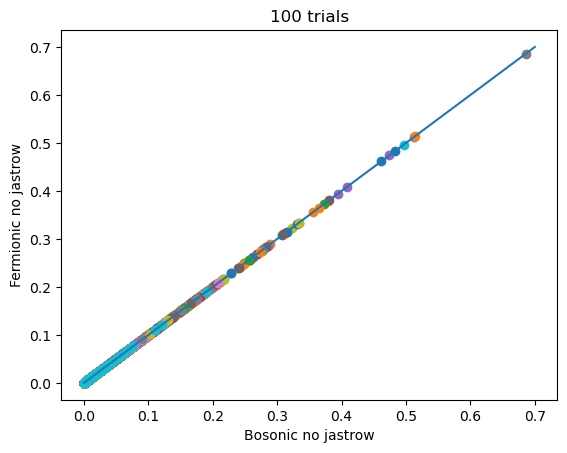

In [16]:
trials = 100
for i in range(trials):
    nconfig = 100
    mol, mf = pyscftools.recover_pyscf(scf_checkfile)
    configs = mc.initial_guess(mol, nconfig, seed = i)
    wfb = initialize_boson_qmc_objects(
        scf_checkfile,
    )
    wf = initialize_qmc_objects(
            scf_checkfile,
        )
    e=0
    sign, val = wf.recompute(configs)
    g1, val2, (aograd, mograd) = wf.gradient_value(e, configs.electron(e))  
    e=0
    signb, valb = wfb.recompute(configs)
    g1b, saved = wfb.gradient_value(e, configs.electron(e))
    valb2 = saved['psi']
    plt.scatter(np.exp(val), valb)
x = np.linspace(0, 0.7, 100)
plt.plot(x,x)
plt.xlabel('Bosonic no jastrow')
plt.ylabel('Fermionic no jastrow')
plt.title(str(trials) + ' trials')

Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in the bosonic wavefunction= 1
Number of determinants in th

Text(0.5, 1.0, '100 configurations')

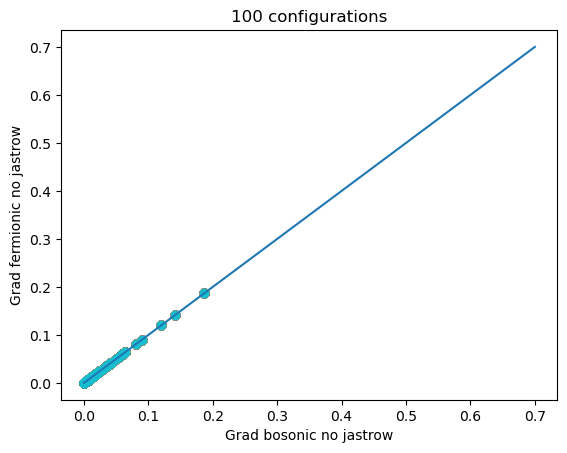

In [28]:
trials = 100
for i in range(trials):
    nconfig = 100
    mol, mf = pyscftools.recover_pyscf(scf_checkfile)
    configs = mc.initial_guess(mol, nconfig, seed = 1100)
    wfb = initialize_boson_qmc_objects(
        scf_checkfile,
    )
    wf = initialize_qmc_objects(
            scf_checkfile,
        )
    e=0
    sign, val = wf.recompute(configs)
    g1, val2, (aograd, mograd) = wf.gradient_value(e, configs.electron(e))  
    e=0
    signb, valb = wfb.recompute(configs)
    g1b, saved = wfb.gradient_value(e, configs.electron(e))
    valb = saved['psi']
    plt.scatter(np.exp(val), valb)
x = np.linspace(0, 0.7, 100)
plt.plot(x,x)
plt.xlabel('Grad bosonic no jastrow')
plt.ylabel('Grad fermionic no jastrow')
plt.title(str(trials) + ' configurations')